# Generative Models

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


As already explained, for learning methods with a very large hypothesis space $\mathcal{H}$, model uncertainty essentially disappears, while approximation uncertainty might be high. In particular, this includes learning methods with high flexibility, such as (deep) neural networks and nearest neighbors. In methods of that kind, there is no explicit assumption about a global structure of the dependency between inputs $\vec{x}$ and outcomes $y$. Therefore, inductive inference will essentially be of a local nature: A class $y$ is approximated by the region in the instance space in which examples from that class have been seen, aleatoric uncertainty occurs where such regions are overlapping, and epistemic uncertainty where no examples have been encountered so far (cf.\ Fig. {numref}`plc`).  




:::{figure-md} plc
<img src="pic-local-combined.jpg"  width="600px">

If a hypothesis space is very rich, so that it can essentially produce every decision boundary, the epistemic uncertainty is high in sparsely populated regions without training examples. The lower query point in the left picture, for example, could easily be classified as red (middle picture) but also as black (right picture). In contrast to this, the second query is in a region where the two class distributions are overlapping, and where the aleatoric uncertainty is high.
:::

An intuitive idea, then, is to consider generative models to quantify epistemic uncertainty. Such approaches typically look at the densities $P(\vec{x})$ to decide whether input points are located in regions with high or low density, in which the latter acts as a proxy for a high epistemic uncertainty. The density $P(\vec{x})$ can be estimated with traditional methods, such as kernel density estimation or Gaussian mixtures.
To visualize this idea in a real example, let's analyze the world of chess. The rise of online chess has helped to popularize this traditional game even more, reaching out to new potential players all around the world. This has allowed for an ever-increasing amount of professional chess tournaments online. However, online tournaments make anti-cheating measures difficult to implement. The following code simulates anomaly detection in the context of online chess. Here, two methods are implemented: Kernel Density Estimation (KDE) and Gaussian Mixture Model Density Estimation (GMM). The data points are randomly generated and represent the relationship between accuracy (compared to a chess engine) and the Elo rating of a player, These points are purposely distributed along a diagonal line with three separated regions, with the central region having high density and the regions at both ends of the diagonal having low density (epistemic uncertainty). Here the data points are represented in the feature space defined by Elo Rating (x-axis) and Accuracy (y-axis). The color of each point indicates the estimated density of that point. Brighter colors represent higher densities, while darker colors represent lower densities. A scale for the density values is illustrated as a color bar on the right of the plot. Higher density regions (brighter colors, yellow and red) correspond to areas where more data points are concentrated and lower density regions (darker colors, blue) indicate areas with fewer data points, potentially highlighting anomalies.


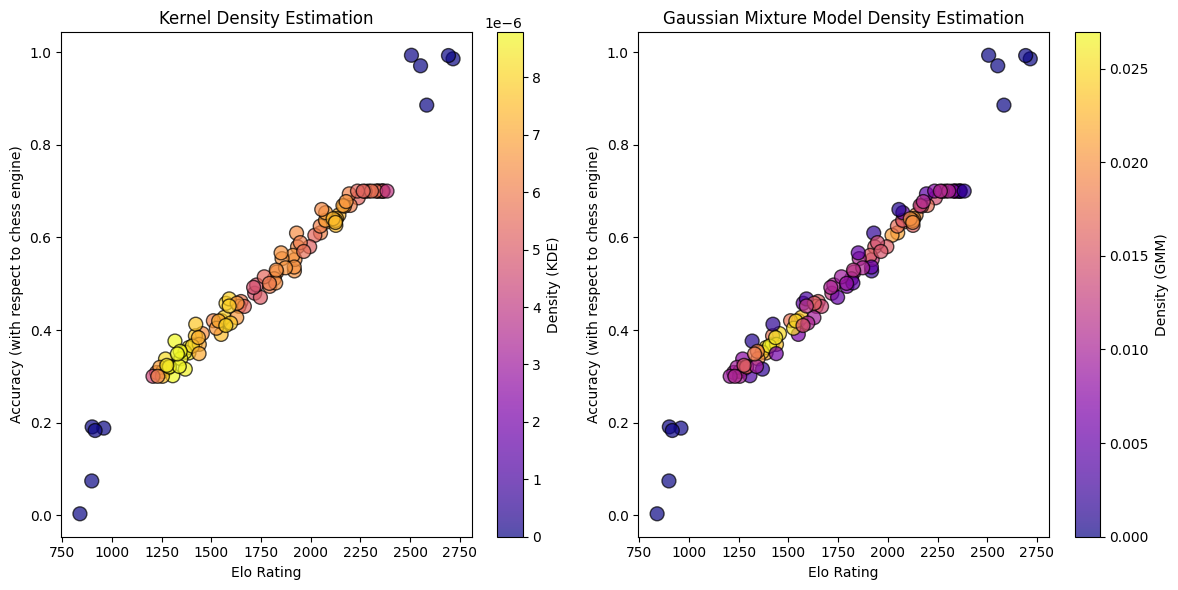

In [9]:

# synthetic data 
np.random.seed(42)

# Generate normal data with a diagonal correlation between Elo rating and accuracy
normal_elo_ratings = np.random.uniform(1200, 2400, 100)
normal_accuracies = 0.0004 * normal_elo_ratings - 0.2 + np.random.normal(0, 0.02, 100)  # Diagonal trend with noise
normal_accuracies = np.clip(normal_accuracies, 0.3, 0.7)  
normal_data = np.column_stack((normal_elo_ratings, normal_accuracies))

# Anomalous data points 
anomalous_elo_ratings = np.concatenate((np.random.uniform(800, 1000, 5), np.random.uniform(2500, 2800, 5)))
anomalous_accuracies = np.concatenate((np.random.uniform(0.0, 0.2, 5), np.random.uniform(0.8, 1.0, 5)))
anomalous_data = np.column_stack((anomalous_elo_ratings, anomalous_accuracies))

data = np.vstack([normal_data, anomalous_data])

# Kernel Density Estimation (KDE)
kde = KernelDensity(bandwidth=50.0)
kde.fit(normal_data)
log_density = kde.score_samples(data)
density = np.exp(log_density)

# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2)
gmm.fit(normal_data)
gmm_density = np.exp(gmm.score_samples(data))

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=density, cmap='plasma', edgecolor='k', alpha=0.7, s=100)
plt.colorbar(label='Density (KDE)')
plt.title('Kernel Density Estimation')
plt.xlabel('Elo Rating')
plt.ylabel('Accuracy (with respect to chess engine)')

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=gmm_density, cmap='plasma', edgecolor='k', alpha=0.7, s=100)
plt.colorbar(label='Density (GMM)')
plt.title('Gaussian Mixture Model Density Estimation')
plt.xlabel('Elo Rating')
plt.ylabel('Accuracy (with respect to chess engine)')

plt.tight_layout()
plt.show()


 Yet, novel density estimation methods still appear in the machine learning literature. Some more recent approaches in this area include isolation forests ({cite:t}`Liu_isolationforest`), auto-encoders ({cite:t}`Goodfellow2016`), and radial basis function networks ({cite:t}`Bazargami2019`). Of course, we can also apply these newer methods to the previous example of anti-cheating in chess. Let's take the Isolation Forests as an example. Isolation Forest is an anomaly detection algorithm that isolates data points by randomly selecting a feature and a split value (with respect to the feature). The more quickly a point is isolated, the more likely it is to be an anomaly. So, if a point gets separated out with just a few splits, it's considered more unusual. In the context of chess the features can be seen as Elo rating or accuracy. The data points follow the same distribution along the diagonal line; however, more points are added to provide more information about normal and anomalous points for the training of the models. 



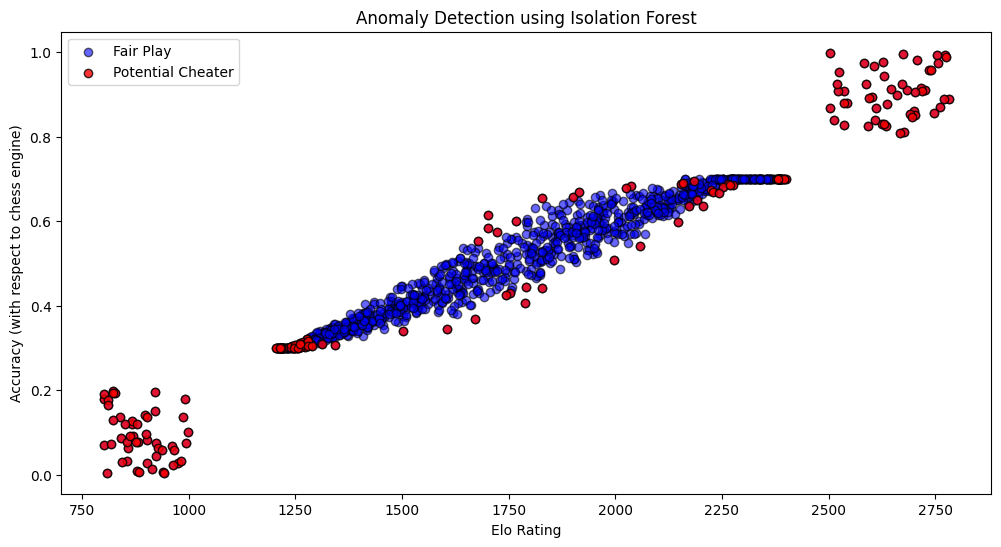

In [10]:

# Synthetic data 
np.random.seed(42)

# Generate normal data with a diagonal correlation between Elo rating and accuracy.
normal_elo_ratings = np.random.uniform(1200, 2400, 1000)
middle_index = (normal_elo_ratings - 1200) / (2400 - 1200)  # Normalize Elo ratings to range [0, 1]
noise = np.where(middle_index < 0.5, middle_index, 1 - middle_index)  # Create more noise in the middle
normal_accuracies = 0.0004 * normal_elo_ratings - 0.2 + np.random.normal(0, noise * 0.1, 1000)  
normal_accuracies = np.clip(normal_accuracies, 0.3, 0.7)  
normal_data = np.column_stack((normal_elo_ratings, normal_accuracies))

# Generate anomalous data points 
anomalous_elo_ratings = np.concatenate((np.random.uniform(800, 1000, 50), np.random.uniform(2500, 2800, 50)))
anomalous_accuracies = np.concatenate((np.random.uniform(0.0, 0.2, 50), np.random.uniform(0.8, 1.0, 50)))
anomalous_data = np.column_stack((anomalous_elo_ratings, anomalous_accuracies))

data = np.vstack([normal_data, anomalous_data])
train_data, test_data = train_test_split(normal_data, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
all_data_tensor = torch.tensor(data, dtype=torch.float32)

# Train Isolation Forest 
iso_forest = IsolationForest(contamination=0.1)
iso_forest.fit(normal_data)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(data)
anomalies = iso_forest.predict(data) == -1

plt.figure(figsize=(12, 6))
plt.scatter(data[:, 0], data[:, 1], c='blue', label='Fair Play', alpha=0.6, edgecolor='k')
plt.scatter(data[anomalies, 0], data[anomalies, 1], c='red', label='Potential Cheater', alpha=0.8, edgecolor='k')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Elo Rating')
plt.ylabel('Accuracy (with respect to chess engine)')
plt.legend()
plt.show()

As shown by these methods, density estimation is also a central building block in anomaly and outlier detection. Often, a threshold is applied on top of the density $P(\vec{x})$ to decide whether a data point is an outlier or not. For example, in auto-encoders, a low-dimensional representation of the original input in constructed, and the reconstruction error can be used as a measure of support of a data point within the underlying distribution. A simple implementation of this concept is shown here following the anti-cheating chess example. Here, the threshold for the reconstruction error was set at the 98th percentile.

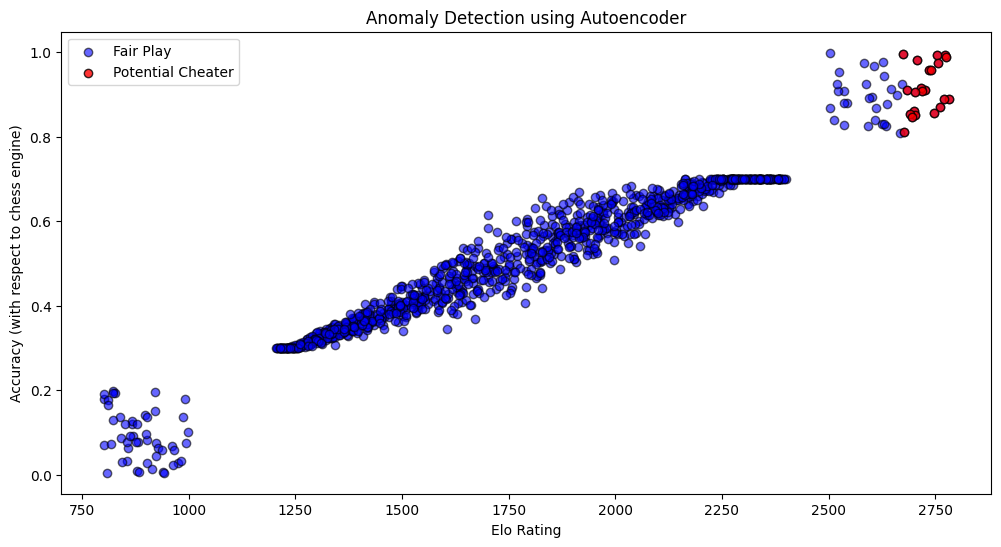

In [11]:

train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=32, shuffle=True)

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = train_data.shape[1]
encoding_dim = 2

model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Autoencoder 
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, _ in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Reconstruction Error
model.eval()
with torch.no_grad():
    reconstructions = model(all_data_tensor)
    reconstruction_errors = torch.mean((all_data_tensor - reconstructions) ** 2, dim=1).numpy()

# Set a Threshold for Anomaly Detection
threshold = np.percentile(reconstruction_errors, 98)  # 98th percentile

# Identify anomalies
anomalies = reconstruction_errors > threshold

plt.figure(figsize=(12, 6))
plt.scatter(data[:, 0], data[:, 1], c='blue', label='Fair Play', alpha=0.6, edgecolor='k')
plt.scatter(data[anomalies, 0], data[anomalies, 1], c='red', label='Potential Cheater', alpha=0.8, edgecolor='k')
plt.title('Anomaly Detection using Autoencoder')
plt.xlabel('Elo Rating')
plt.ylabel('Accuracy (with respect to chess engine)')
plt.legend()
plt.show()

Methods of that kind can be classified as semi-supervised outlier detection methods, in contrast to supervised methods, which use annotated outliers during training. Many semi-supervised outlier detection methods are inspired by one-class support vector machines (SVMs), which fit a hyperplane that separates outliers from "normal" data points in a high-dimensional space ({cite:t}`Khan_2014`). Some variations exist, where for example a hypersphere instead of a hyperplane is fitted to the data ({cite:t}`Tax2004`). 


Outlier detection is also somewhat related to the setting of classification with a reject option, e.g., when the classifier refuses to predict a label in low-density regions ({cite:t}`pere_bc16`). For example, ({cite:t}`ziyin2019deep`) adopt this viewpoint in an optimization framework where an outlier detector and a standard classifier are jointly optimized. Since a data point is rejected if it is an outlier, the focus is here on epistemic uncertainty. In contrast, most papers on classification with reject option employ a reasoning on conditional class probabilities $P(y \in \vec{x})$, using specific utility scores. These approaches rather capture aleatoric uncertainty (see also Section [Set-valued Prediction Based on Utility Maximization](../chapter-setValued_utilityMaximization/set)), showing that seemingly related papers adopting the same terminology can have different notions of uncertainty in mind. 

In recent papers, outlier detection is often combined with the idea of set-valued prediction (to be further discussed in Sections ( [Credal Sets and Classifiers](../chapter-credal_sets/credal_sets) ) and ( [Conformal Prediction for Classification](../chapter-conformel_classification/conformel_classification))). Here, three scenarios can occur for a multi-class classifier: 
(i) A single class is predicted. In this case, the epistemic and aleatoric uncertainty are both assumed to be sufficiently low. 
(ii) The "null set" (empty set) is predicted, i.e., the classifier abstains when there is not enough support for making a prediction. Here, the epistemic uncertainty is too high to make a prediction.  
(iii) A set of cardinality bigger than one is predicted. Here, the aleatoric uncertainty is too high, while the epistemic uncertainty is assumed to be sufficiently low.   

({cite:t}`hech_cd19`) implement this idea by fitting a generative model $P(\vec{x}\in y)$ per class, and predicting null sets for data points that have a too low density for any of those generative models. A set of cardinality one is predicted when the data point has a sufficiently high density for exactly one of the models $P(\vec{x} \in y)$, and a set of higher cardinality is returned when this happens for more than one of the models. 
({cite:t}`feng_sp19`) propose a different framework with the same reasoning in mind. Here, a pair of models is fitted in a joint optimization problem. The first model acts as an outlier detector that intends to reject as few instances as possible, whereas the second model optimizes a set-based utility score. The joint optimization problem is therefore a linear combination of two objectives that capture, respectively, components of epistemic and aleatoric uncertainty. 

Generative models often deliver intuitive solutions to the quantification of epistemic and aleatoric uncertainty. In particular, the distinction between the two types of uncertainty explained above corresponds to what ({cite:t}`mpub169`) called "conflict" (overlapping distributions, evidence in favor of more than one class) and "ignorance" (sparsely populated region, lack of evidence in favor of any class). Yet, like essentially all other methods discussed in this section, they also have disadvantages. An inherent problem with semi-supervised outlier detection methods is how to define the threshold that decides whether a data point is an outlier or not. Another issue  is how to choose the model class for the generative model. Density estimation is a difficult problem, which, to be successful, typically requires a lot of data. When the sample size is small, specifying the right model class is not an easy task, so the model uncertainty will typically be high. 